# Specialized neural networks 

In the previous lecture, we found that a pretty generic multilayer perceptron could predict discharge with reasonable accuracy. We could use a similar model to classify our images but it wouldn't really make sense given that a fully-connected multilayer perceptron would treat all pixels independently and have no conception of **spatial structure**. 

In this lecture, we will introduce a special type of neural network architecture called **convolutional networks**. The architecture makes convolutional networks fast to train, able to to identify spatial structure, and very good at image classification. These type of networks have rapidly advanced the field of computer vision and have the potential to dramatically expand the kinds of Earth Science questions we ask from satellite images.

## Example - how much water is in these satellite images?

We will return to our image classification task to demonstrate convolutional networks. In this demo, we have **100 tiles** of the ice sheet surface acquired by SkySat. These tiles have dimensions of **320 x 320 x 4** which represent the number of rows, columns, and bands (i.e. RGB-NIR) in the satellite image. Alongside these tiles, we have a table that contains the **fraction of water** in each tile (i.e. labels). 

```{important}
Our goal is to train a convolutional network to predict water fraction from information contained in the tiles (e.g. spectral reflectance, spatial structure). 
```

In [1]:
# Import packages
import matplotlib.pyplot as plt
import glob
import rasterio
import numpy as np
import pandas as pd

# Define labels
df = pd.read_csv('data/water-fraction.csv')

# Define tiles
tiles = sorted(glob.glob('data/tiles/*.tif'))
print(len(tiles))

100


In [2]:
print(df['fraction'])

0     0.000000
1     0.000000
2     0.000000
3     0.011221
4     0.000400
        ...   
95    0.059541
96    0.111094
97    0.142324
98    0.158281
99    0.157617
Name: fraction, Length: 100, dtype: float64


Let's also show some examples of the tiles.

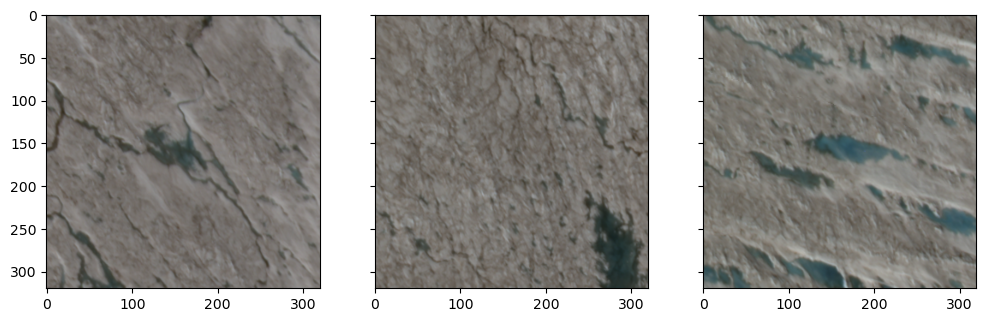

In [3]:
rgbs = []
for i in [6, 7, 8]:
    with rasterio.open(tiles[i]) as src:
        bands = [src.read(j) for j in range(1, 4)]
        rgbs.append(np.dstack(bands[::-1]))

# Plot as RGB images
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
for ax, rgb in zip(axes, rgbs):
    ax.imshow(rgb)
plt.show()

## Segmentation vs. classification

Given our previous experience with this task, our first intuition might be to classify every pixel in the tile as water or non-water, then sume the number of water pixels. This would be called **semantic segmentation** and it is a perfectly reasonable approach. However, since our goal is just to quantify how much water is in every tile, that might be overkill. 

Instead, we are just going to predict a single label (a continuous value between 0 and 1) for every tile. This kind of task is (perhaps confusingly) called **image classification** in computer science. What we're doing is therefore similar to other image recognition tasks where the model processes an image and assigns a single categorical label (e.g. dog, cat, car).

## Architecture

We will be using `TensorFlow` again to define our convolutional network. 

In [4]:
from tensorflow.keras import layers, models

# Define image size
img_size = src.width, src.height, src.count

# Define model
def build_cnn(input_shape=(img_size)):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(16, (5,5), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(16, (5,5), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(16, (5,5), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),

        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='mse',  
                  metrics=['mae'])
    return model

model = build_cnn()

ModuleNotFoundError: No module named 'tensorflow'

## Local receptive fields

We'll notice that our convolutional network has some different **types of layers**. The first type is called a `Conv2D` (2D convolution layer) which we can think of as a **filtering operation** (or window). The filter (or local receptive field) in our model has a size of **5 x 5 pixels**. We can slide this filter across our image and apply a function (i.e. a convolution) to map values from the input layer onto the next layer. 

```{image} images/filter.png
:width: 700px
:align: center
```

In traditional image processing, we would manually define the **weights** of the filter. For example we could use a Gaussian filter to reduce noise or a Laplacian filter to enhance edges. Our `Conv2D` layer however initializes the 5 x 5 kernel weights **randomly**. During training, backpropagation updates those weights so that the filter outputs different spatial structures (e.g. water boundaries, textures, shapes). We have set our `Conv2D` layer to produce **16 different filters** (or feature maps). 

```{note}
Our `Conv2D` layer converts our 320 x 320 x 4 image into 316 x 316 x 16 feature maps because we can only move the local receptive field 316 nodes across (or 316 nodes down) before colliding with the right-hand side (or bottom) of the input image.
```

## Shared weights and biases

We might be thinking that the number of parameters of a convolutional network must be huge. For example, a 320 x 320 x 4 image would have 409,600 input nodes. If these were fully-connected to 32 nodes in a hidden layer (a relatively modest number), the number of parameters would be over 13 million. However, when we print our `model.summary()` we find that our `Conv2D` layer **only has 1,616 parameters**. How can this be?

Whereas layers in our multilayer perceptron were fully-connected, each feature map (16 of them) is produced using a kernel that uses the **same weights and bias across the entire image**. In other words, the first `Conv2D` layer detects exactly the same feature, just at different locations in the input image. This is advantageous because nodes in this layer that learn how to detect a particular feature in one part of the image will also be able to detect the same feature in other places in the image.

The number of parameters for a `Conv2D` layer is therefore a function of 1) the size of the kernel (each pixel in the kernel must have a weight), 2) the number of bands in the input image, and 3) the number of feature maps. For our first `Conv2D` layer, this would be: (5 x 5 x 4 + 1) x 16 = 1,616. For our second `Conv2D` layer, this would be: (5 x 5 x 16 + 1) x 16 = 1,616, noting that the previous convolutional layer **increased the number of bands to 16**.  

```{image} images/kernel-weights.png
:width: 500px
:align: center
```

Most of the parameters in our convolutional network are therefore the weights associate with our 5 x 5 kernels. Above is an example of what these kernels may look like. Whiter colors represent smaller weights and darker weights represent larger weights. The weights in each kernel are continuously updated during training so that they become more or less sensitive to spatial structure in our image (e.g. edges). 

By substantially reducing the number of parameters in our model, shared weights will allow us train our convolutional networks faster which, in turn, will allow us to experiment with developing deeper networks. Sharing weights therefore enables the development of complex models without the computational overhead. This alone is a major reason for why convolutional networks have made so many breakthroughs in machine learning. 

In [105]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 316, 316, 16)   │         1,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 158, 158, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 154, 154, 16)   │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 77, 77, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 73, 73, 16)     │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 36, 36, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,601 (60.94 KB)

 Trainable params: 15,601 (60.94 KB)

 Non-trainable params: 0 (0.00 B)

## Pooling

The second type of layer we use in convolutional networks is a **pooling layer**. These layers **downsample** the outputs produced by a convolutional layer so are usually used immediately the `Conv2D` layers. In our model, we defined `MaxPooling2D((2,2))` which simply outputs the maximum activation for each 2 x 2 input region in our image. There are other pooling techniques such as **L2 pooling** which compute the square root of the sum of the squares of the activations in the 2 x 2 region. 

```{image} images/pooling.png
:width: 700px
:align: center
```

Pooling using a 2 x 2 input region reduces the number of nodes in our network by half. Hence the output of the pooling layer has a dimension of 158 x 158 x 16. This is useful for increasing computational efficiency. It may also make the model more robust to slight variations in the position of features, thereby improving a property known as **translational invariance**. 

Towards the end of our network, we use another type of pooling layer called `GlobalAveragePooling2D`. This layer averages each feature map to a single nodes. In our case, 16 feature maps because 16 nodes. Again there are several reasons for this layer including computational efficiency, prevention of overfitting. It also ensures the network focuses on whether a feature exists, not *where* it is.

## Fully-connected neural network

The final couple of layers of our network are fully-connected, just like the multilayer perceptron we described in the previous lecture. We first have a `Dense` layer that connects all 16 nodes from the `GlobalAveragePooling2D` layer to every one of the 64 output nodes. We then have another `Dense` layer that connects all 64 of these nodes to a single node which is subsequently normalized using a `sigmoid` activation function to predict a value between 0 and 1. 

## Network training

Now we have some understanding of the convolutional network, let's train it. First we will define some helper functions to read the GeoTiff tiles and convert them into a a tensorflow dataset. 

In [106]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Function to load GeoTIFF with rasterio
def _load_geotiff(path):
    with rasterio.open(path) as src:
        img = src.read([1, 2, 3, 4])
        img = np.transpose(img, (1, 2, 0))
    return img.astype("float32")

# TensorFlow wrapper
def load_image(path, label):
    img = tf.numpy_function(
        func=lambda p: _load_geotiff(p.decode("utf-8")),
        inp=[path],
        Tout=tf.float32
    )
    img.set_shape((img_size))
    img = img / 255.0
    return img, tf.cast(label, tf.float32)

# Make TF dataset
def make_dataset(files, labels, batch_size=10, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(files))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

Now we will split into training, testing, and validation datasets. 

In [107]:
# Split
train_files, test_files, train_labels, test_labels = train_test_split(
    df["tile"], df["fraction"], test_size=0.2, random_state=42)

train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.25, random_state=42)

train_ds = make_dataset(train_files.values, train_labels.values)
val_ds   = make_dataset(val_files.values, val_labels.values, shuffle=False)
test_ds  = make_dataset(test_files.values, test_labels.values, shuffle=False)

It might be possible to train our model using all 100 image-label pairs but, in most cases, our training dataset will be too large to load into memory all at once. We therefore train the model in batches. We can inspect one batch like so:

In [108]:
for batch in train_ds.take(1):
    print(batch[0].shape) 
    print(batch[1].shape)

(10, 320, 320, 4)
(10,)


This tells us that each batch contains 10 tiles with 10 corresponding labels. 

## Fit and evaluate model

We fit the model to the training dataset, using the the validation dataset to monitor the model performance. 

In [119]:
# Fit model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=0
)

In [120]:
# Evaluate
model.evaluate(test_ds, verbose=0)
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Final test accuracy: {test_acc:.3f} or {(test_acc/df['fraction'].mean())*100:.1f}%")

Final test accuracy: 0.027 or 12.7%


In [121]:
# Predict all test images
predicted = []
actual = []
for i in range(len(test_files)):
    
    # Load the image
    src = rasterio.open(test_files.iloc[i])
    img = src.read([1, 2, 3, 4])
    img = img.astype(np.float32)
    img = img / 255.0
    img = np.moveaxis(img, 0, -1)
    
    # Add batch dimension
    img = tf.expand_dims(img, axis=0)

    # Make prediction
    prediction = model.predict(img, verbose=0)
       
    # Append
    predicted.append(prediction[0][0])
    actual.append(test_labels.iloc[i])

results = pd.DataFrame(list(zip(actual, predicted)), columns=['actual', 'predicted'])
results.head()

,actual,predicted
0,0.358291,0.284476
1,0.052187,0.025802
2,0.062305,0.062378
3,0.655342,0.595010
4,0.945088,0.937685


Text(0, 0.5, 'Predicted water fraction')

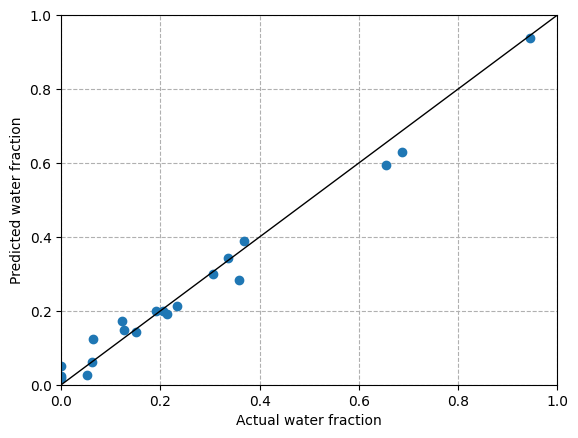

In [122]:
plt.scatter(actual, predicted, zorder=2)
plt.plot([0,1],[0,1], color='k', lw=1)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(ls='dashed', zorder=1)
plt.xlabel('Actual water fraction')
plt.ylabel('Predicted water fraction')

## Further reading

Bishop, C. M. (2006). [Pattern recognition and machine learning](https://link.springer.com/9780387310732)

Goodfellow, I., Bengio, Y., & Courville, A. (2017) [Deep learning](https://www.deeplearningbook.org/)

Karn, U. (2016). [An Intuitive Explanation of Convolutional Neural Networks](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/)

Nielsen, M. A. (2015). [Neural networks and deep learning](http://neuralnetworksanddeeplearning.com/index.html)

Rohrer, B. (2019). [How convolutional neural networks work, in depth](https://www.youtube.com/watch?v=JB8T_zN7ZC0)